# Modeling Personal Loan Delinquency with LendingClub Data

The domain of our project is peer-to-peer consumer lending. Our goal is to model credit risk on personal loans, more precisely to evaluate the probability of default or delinquency of borrowers during their loan period.

LendingClub loans are made over either a 36 or 60 month term, with a variety of statistics reported about each unique loan on a monthly basis (our analysis focuses on the 36 month terms). Our variable of interest is called `loan_status` which has eight possible states. We attempt to model credit risk by estimating the probability of a loan transitioning between any two of these states at any month during the loan term. Below are the eight `loan_status` states, with descriptions from LendingClub's [website](https://help.lendingclub.com/hc/en-us/articles/215488038-What-do-the-different-Note-statuses-mean-):

- **Issued**: New loan that has passed all LendingClub reviews, received full funding, and has been issued.

- **Current**: Loan is up to date on all outstanding payments. 

- **In Grace Period**: Loan payment is late, but within the 15-day grace period.
 
- **Late (16-30)**: Loan is late, past the grace period, hasn't been current for 16 to 30 days.
 
- **Late (31-120)**: Loan has not been current for 31 to 120 days.
 
- **Charged Off**: Loan for which there is no longer a reasonable expectation of further payments. Charge Off typically occurs when a loan is 120 days or more past due and there is no reasonable expectation of sufficient payment to prevent the charge off. Loans for which borrowers have filed for bankruptcy may be charged off earlier.

- **Default**: Loan has not been current for an extended period of time. Charged off and default states are similar, yet different. [TODO explain]

- **Fully paid**: Loan has been fully repaid, either at the expiration of the 3- or 5-year year term or as a result of a prepayment.

To model the transition states month over month, we employed a stationary discrete time step Markov Chain model. Discrete because our data is on a monthly basis, and stationary because we assume the probability distribution of  transition is independent of time (we use the same model across all month). Recall the Markov property, or the "memoryless" assumption, that for some sequence of events, that the conditional probability of the next time step $x_t$ depends only upon the previous time step $x_{t-1}$, ignoring all time steps that preceded it:

$$
\begin{align*}
p(X_t = x_t | X_{t-1} = x_{t-1}, X_{t-2} = x_{t-2}, ... , X_0 = x_0) = p(X_t = x_t | X_{t-1})
\end{align*}
$$

For a discrete time Markov Chain, the joint distribution for the probability of some sequence length $T$ can then be written as:

$$
\begin{align*}
p(X_{1:T}) = p(X_1)p(X_2 | X_1) p(X_3 | X_2) ... = p(X_1)\prod_{t=2}^{T}p(X_t | X_{t-1})
\end{align*}
$$

[Murphy, 2012, p. 589](#References)

For $K$ outcome states, the conditional distribution $p(X_t | X_{t-1})$ can be written as a $K \times K$ transition matrix (denoted $A$) where $A_jk  = p(X_t = k | X_{t-1} = j)$ (the probability of transitioning from states $j$ to state $k$, where each row in the matrix can be thought of as a probability mass function). In our case $K=8$ and we have an $8 \times 8$ transition matrix. The goal of our analysis, then, is to estimate the posterior probabilities of this transition matrix using our observed data.

## Data

Our dataset consists of approximately 40 million observations from loans spanning between 2007 through Q3 2018. The dataset includes dozens of fields, however for our Markov model (and to simplify data management) we only need to work with 4 features: `id`, `loan_status`, `term`, and `age_of_loan`. During preprocessing, we also filtered out all loans with a 60 month term and 36 term loans that extended beyond 36 months, reducing our dataset to around 27 million observations. In total, we have just under 1.5 million unique loans, which can be seen in the rows column after we split and pivot our data below.

In [1]:
from utils.utils import load_dataframe, preprocess, split_data
from utils.models import build_mle_matrix, build_mc_no_priors, build_mc_with_priors, build_mc_non_stationary
from utils.inference import compute_mle, infer_mc_no_priors, infer_mc_with_priors, infer_mc_non_stationary
from utils.criticism import sample_mle, plot_sampled_lengths, graph_trajectory, plot_probs_from_state_j
import numpy as np
import pandas as pd

In [2]:
df = load_dataframe()

Loading raw data from cache...
Retrieved 40,224,444 rows, 4 columns in 2.91 seconds


In [3]:
df = preprocess(df)

Mapping column names...
Loading preprocessed data from cache...
Retrieved 27,606,653 rows, 4 columns in 0.88 seconds


In [4]:
x_train, x_test = split_data(df)

Loading split data from cache...
Retrieved 1,508,656 rows, 36 columns in 0.37 seconds
Train: (1357828, 36) | Test: (150828, 36)


In [5]:
chain_len = max(df.age_of_loan)
n_states = df.loan_status.unique().shape[0]

## Experiment 1: Markov Model with Maximum Likelihood Estimates

### 1.1 Model

To get some intuition on how to estimate the transition matrix given our training data, $N$, we start with MLE estimation. The MLE solution of a Markov Chain is simply the empirical frequencies of each transition. Formally, the probability of some particular sequence length $T$, with transition matrix $A$ and states $K$ is given by: 

$$ 
\begin{align*}
p(x_{1:T}|\theta) = p(x_1)A(x_1, x_2)...A(x_{T-1}, x_T) 
&= \prod_{j=1}^{K}(p_j)^{\mathbb{I}(x_1 = j)} \prod_{t=2}^{T} \prod_{j=1}^{K} \prod_{k=1}^{K}(A_{jk})^{\mathbb{I}(x_{t-1} = j, x_t = k)}
\end{align*}
$$

It is relatively easy to show that the MLEs for $p_j$ (at state $j$) and $A_{jk}$ (at transition from states $j$ to $k$) are given by the observed frequencies:  
$$ 
\begin{align*}
p_j = \frac{\sum_{i=1}^N\mathbb{I}(x_{i1} = j)}{\sum_{j}\sum_{i=1}^N\mathbb{I}(x_{i1} = j)}
\end{align*}
$$

$$ 
\begin{align*}
A_{jk} = \frac{\sum_{i=1}^N\sum_{t=1}^{T-1} \mathbb{I}(x_{i,t} = j, x_{i,t+1} = k)}{\sum_k\sum_{i=1}^N\sum_{t=1}^{T-1} \mathbb{I}(x_{i,t} = j, x_{i,t+1} = k)}
\end{align*}
$$

[Murphy, 2012, pp. 592–593](#References)

In more colloquial terms, the estimator for $p$ in any given outcome state $j$ is the number of times we observed $j$ at time $t=1$ in our training data, divided by the total number of observations at time $t=1$. Similarly, the estimator for $A$ of transitioning from state $j$ to state $k$ is given by the total number of times we observed a transition from state $j$ to state $k$, divided by the total number of times we observed a transition from state $j$ to any other state. For our purposes, we ignore $p$ and just generate MLE estimates for the transition matrix $A$. Even though we want to solve the problem from a Bayesian perspective, our first experiment with MLEs is relatively easy to obtain and should give us a reasonable baseline to compare other models against.

In [6]:
realized_transitions = build_mle_matrix(df)

Loading transitions data from cache...
Retrieved 7 rows, 7 columns in 0.01 seconds


In [7]:
realized_transitions

,Charged Off,Current,Default,Fully Paid,In Grace Period,Late (16-30 days),Late (31-120 days)
Charged Off,0,0,0,0,0,0,0
Current,774,24449524,3,707169,5830,160360,62088
Default,28897,147,2297,71,0,4,506
Fully Paid,0,0,0,8026,12,101,72
In Grace Period,0,276,0,11,22,59,41
Late (16-30 days),4548,32376,0,2066,257,13413,119621
Late (31-120 days),105934,25434,29802,2146,56,3292,332762


Note that `Charged Off` is a "sink" state, therefore there were no observations out of `Charged Off` and we simply filled this column with zeros. The other transition counts represent all observed loan transitions for 36 month term loans between 2007 to Q3 2018.

### 1.2 Inference

Now that we have built a matrix of the realized state transitions, we use it to compute the MLE estimate of $A_{jk}$ from above, for each combination of $j$ and $k$.

In [8]:
mle = compute_mle(realized_transitions)

In [9]:
mle

,Charged Off,Current,Default,Fully Paid,In Grace Period,Late (16-30 days),Late (31-120 days)
Charged Off,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Current,0.000030,0.963120,0.000000,0.027857,0.000230,0.006317,0.002446
Default,0.905238,0.004605,0.071957,0.002224,0.000000,0.000125,0.015851
Fully Paid,0.000000,0.000000,0.000000,0.977469,0.001461,0.012301,0.008769
In Grace Period,0.000000,0.674817,0.000000,0.026895,0.053790,0.144254,0.100244
Late (16-30 days),0.026399,0.187926,0.000000,0.011992,0.001492,0.077855,0.694337
Late (31-120 days),0.212112,0.050926,0.059673,0.004297,0.000112,0.006592,0.666289


### 1.3 Criticism

**Estimates:**

We can see that a lot of the MLE estimates reflect our expectations, for example we can see that:
- A loan which is `Current` is much more likely to stay 'Current' the next month than any other state transition.
- A loan which is in `Default` is very likely to be `Charged Off` the next month than any other state transition.
- Some states are not reachable from other states, for example once `Charged Off`, a loan cannot go to any other state, because LendingClub shuts down the loan completely. Similarly, a loan cannot transition from `Current` to `Late (31-120 days)`, because first it has to go to either `In Grace Period` or `Late (16-30 days)`, since we are measuring data each month.

One problem often observed with MLE estimates for Markov Models is that without enough samples, you may not have observed all the possible states and the transition matrix will show many zero values. A trick to deal with this is called "add-one smoothing" which adds one to all counts before computing the transition probabilities. We initially thought we may have this issue beause some of our transition probabilities are very small. However, since our dataset is very large and the number of states is small, we concluded that we have enough observations that this problem is unlikeley in our case: if a transition has never been observed, we consider that it is not possible, and if the values are very infrequent we believe this is reflective of the true transition probabilties.

**Sampling:**

We can now use these estimates to generate some trajectories. We start at `Current` and keep generating transitions for a period of 36 months, except if we reach `Charged Off` or `Fully Paid` which both are essentially a "sink".

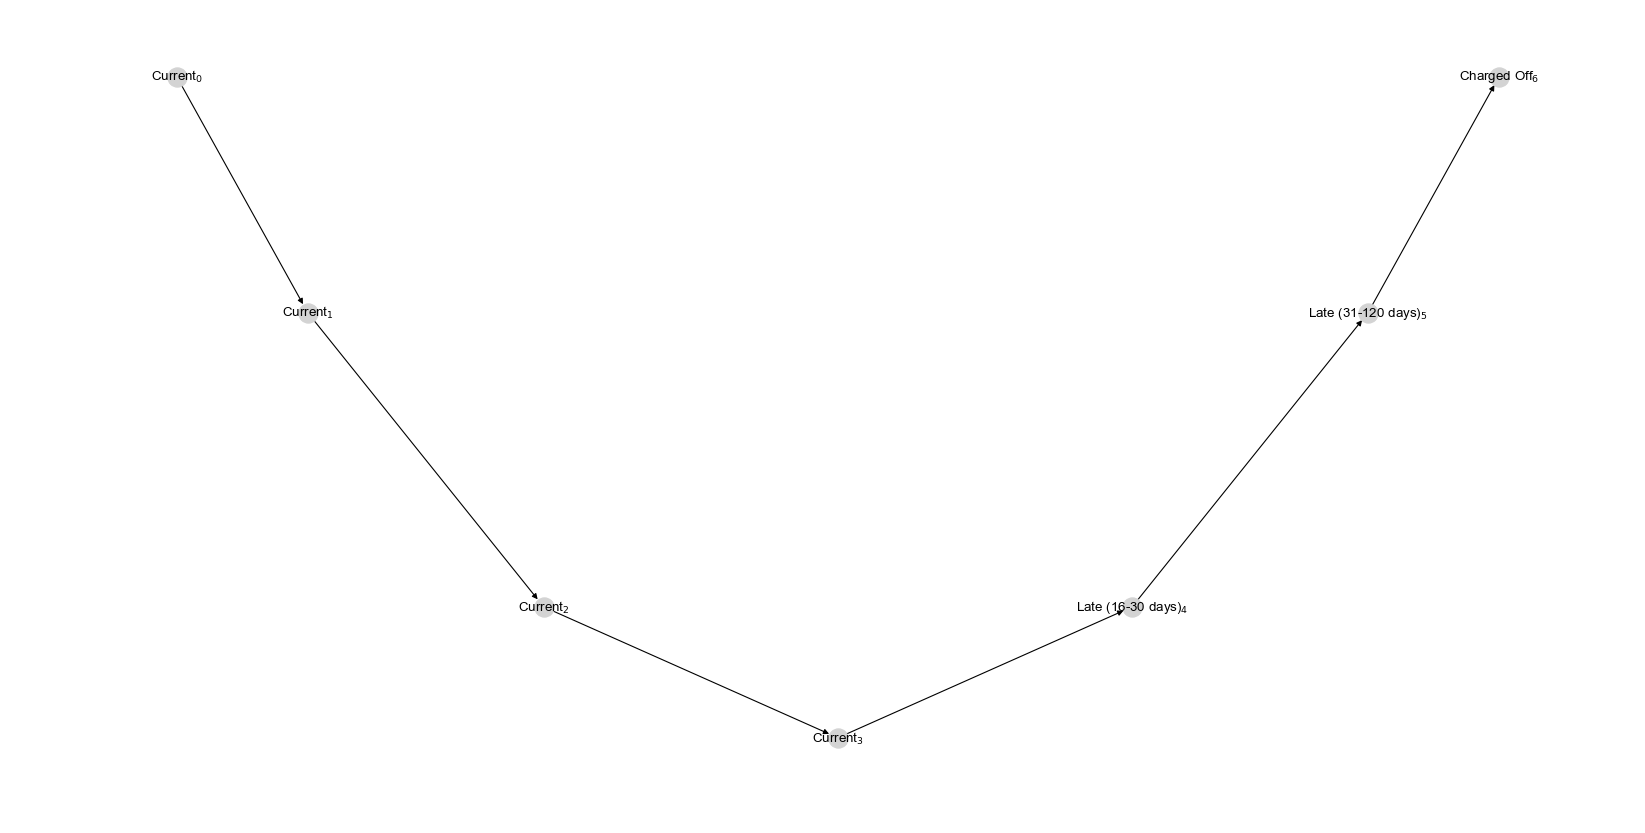

In [20]:
graph_trajectory(sample_mle(mle))

By sampling, we can see limitations of the model itself, for example:
- For Late (31-120), our model doesn't take into account how long has the loan spent in that state. But we do know that after being in that state 4 times, the probability of going to Charged Off is almost 1.

**Looking at statistics based on generated samples:**

One thing we can do is to sample many times and look at the average length of a loan, and compare that to the empirical value in the data:

In [12]:
sampled_trajectories = [sample_mle(mle) for _ in range(10000)]

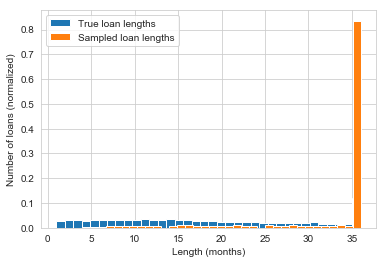

Average length of sampled loans: 32.44 months
Average length of true loans: 18.30 months


In [13]:
plot_sampled_lengths(sampled_trajectories, df)

## Experiment 1 version 2: MLE on extrapolated data

In [36]:
x_train_pivoted = x_train.T.melt().reset_index()
x_train_pivoted.rename({'index': 'age_of_loan', 'value': 'loan_status'}, axis=1, inplace=True)

In [37]:
realized_transitions_extrapolated = utils.models.debug_build_mle_matrix(x_train_pivoted)

Building transition matrix...


In [40]:
realized_transitions

,Charged Off,Current,Default,Fully Paid,In Grace Period,Late (16-30 days),Late (31-120 days)
Charged Off,0,0,0,0,0,0,0
Current,774,24445992,3,707008,5830,160351,61992
Default,28843,147,2206,71,0,4,506
Fully Paid,0,0,0,8026,12,101,72
In Grace Period,0,276,0,11,22,59,41
Late (16-30 days),4548,32374,0,2066,257,13413,119613
Late (31-120 days),105932,25398,29748,2138,56,3292,332463


In [42]:
round(compute_mle(realized_transitions_extrapolated), 2)

,Charged Off,Current,Default,Fully Paid,In Grace Period,Late (16-30 days),Late (31-120 days)
Charged Off,1.00,0.00,0.00,0.00,0.0,0.00,0.00
Current,0.00,0.98,0.00,0.02,0.0,0.00,0.00
Default,0.89,0.00,0.08,0.00,0.0,0.00,0.02
Fully Paid,0.00,0.00,0.00,1.00,0.0,0.00,0.00
In Grace Period,0.00,0.00,0.00,0.00,1.0,0.00,0.00
Late (16-30 days),0.02,0.11,0.00,0.01,0.0,0.44,0.42
Late (31-120 days),0.14,0.03,0.04,0.00,0.0,0.00,0.77


Note:
- seems like IGP -> IGP no longer exists... Might be worth looking more at rows that reach that state
- late 16 - 30 -> Late 16 - 30 much higher than before, used to be 0.08

## Experiment 2: Stationary Dirichlet-Categorical Markov Model (Edward)

### 2.1 Model

The first Bayesian model we built uses the Categorical Distribution to model state transitions, with the Dirichlet Distribution as priors. 

Recall the Categorical Distribution, denoted Cat$(p_1, ..., p_K)$, is a generalization of the Bernoulli Distribution across outcome states, namely, it describes the possible results of a single trial random variable $X$ that can take on one of $K$ possible outcome states, with the probability of each category given by $(p_1, ..., p_K)$. Recall in our scenario, $K=8$ representing the possible `loan_status` states. The probability mass function is then given by:

$$
\begin{align*}
p(X=x | p_1, ..., p_K) = \prod_{j=1}^{K}(p_j)^{\mathbb{I}(x = j)}
\end{align*}
$$

The Dirichlet Distribution, denoted Dir$(a_1, ..., a_K)$, is the conjugate prior of the Categorical Distribution. It describes the probabilities for a K-dimensional vector of random variables $\bar{X}$ with entries in (0,1) and which sum to 1. It should be clear why this makes sense for modelling our Categorical priors. It is parameterixed by $(a_1, ..., a_K)$, called the concentration paramters, which become hyperparameters in our model. The probability density function is given by:

$$
\begin{align*}
p(\bar{X}=[x_1, ..., x_K] | a_1, ..., a_K) = \frac{\Gamma(\sum_{j=1}^K a_j)}{\prod_{j=1}^K \Gamma(a_j)}\prod_{j=1}^K x_j^{a_j - 1}
\end{align*}
$$

The Markov Chain model we specify for transition matrix $A$, outcome states $K=8$ over sequence of months $T=36$ is given by:

$$
\begin{align*}
x_0 &\text{ ~ Cat}(p_1, ..., p_K) \\
x_t &\text{ ~ Cat}_{t-1}(p_1, ..., p_K) \space\space\space\space t \in [1, ..., T] \\
A_j &\text{ ~ Dir}(a_1, ..., a_K) \space\space\space\space j \in [1, ..., K] \\
\end{align*}
$$

Notice that $A_j = [p_1, ..., p_K]$ indicates the $j$th row of the transition matrix, and is not time-dependent since we assume a stationary Markov Chain model with the same transition matrix across time steps. Also note that we are assuming independence of the Categoricals for each $x_t$.

[Tu, 2018](#References)

[Murphy, 2012, p. 594](#References)

In [10]:
batch_size = 1000

In [49]:
x, pi_0, pi_T = build_mc_with_priors(n_states, chain_len, batch_size)

### 2.2 Inference (Batch)

**Parameter tuning**

I tried multiple values for n_samples:
- 5 = what we had initially, somewhat converges
- 1000 = too high, blows up the memory 
- 100 = still goes to NaN with default optimizer; with custom optimizer, doesn't seem to help that much
=> setting to 10 for now

Optimizer:
- lr = 0.01 too high, goes to NaN
- anything higher than 0.005 goes to NaN eventually
- 0.005 what he had so far
- 0.001 not much difference
- adding exponential decay of the lr (what's done by default when not specifying lr) doesn't help either

n_epochs:
- Have been using 10 so far

**TODO:** write down the KLqp loss; think about kl_scaling argument??

Running on 5 epochs: starts around loss 100K, dicreases to around 10K, sometimes goes to NaN right before the end. Takes around 1min to train

In [52]:
inferred_matrix, sess, qpi_0, qpi_T = utils.inference.infer_mc_with_priors(
    x_train, x, pi_0, pi_T, n_states, chain_len, batch_size, lr=0.005)

6767/6785 [ 99%] █████████████████████████████  ETA: 0s | Loss: 10603.808Caching experiment2 data...
Retrieved 7 rows, 7 columns in 49.22 seconds


In [53]:
inferred_matrix

,Charged Off,Current,Default,Fully Paid,In Grace Period,Late (16-30 days),Late (31-120 days)
Charged Off,0.206951,0.075214,0.143969,0.137299,0.117976,0.141233,0.177357
Current,0.038578,0.679605,0.051895,0.060246,0.049125,0.072794,0.047756
Default,0.157851,0.120921,0.166800,0.180365,0.174231,0.089756,0.110077
Fully Paid,0.048633,0.122612,0.070369,0.438960,0.110132,0.109899,0.099394
In Grace Period,0.109583,0.176950,0.206023,0.141662,0.137969,0.093219,0.134595
Late (16-30 days),0.144752,0.230798,0.115761,0.224693,0.077556,0.117728,0.088713
Late (31-120 days),0.091598,0.143830,0.118713,0.204656,0.148960,0.092114,0.200128


### 2.3 Criticism

For the Dirichlet-Categorical we can actually analytically derive the posterior distribution given our dataset $D$, which can then be compared to the numerical solution that we found using Edward's KLqp variational inference algorithm. Based on the model from 2.1 above, the posterior is given by:

$$
\begin{align*}
p(A_j|D, a_1, ..., a_k) &\propto p(A_j|a_1, ..., a_k)\prod_{x_i \in D} p(x_i | p_1, ..., p_K) \\
&\propto \prod_{j=1}^K p_j^{a_j - 1} \prod_{x_i \in D} \prod_{j=1}^{K}(p_j)^{\mathbb{I}(x_i = j)} \\
&\propto \prod_{j=1}^K p_j^{a_j - 1 + \sum_{x_i \in D}\mathbb{I}(x_i = j)}
\end{align*}
$$

Notice that this derived distribution has the form of a Dirichlet with Dir$(a_1^{'}, ..., a_K^{'})$ where $a_j^{'} = a_j + \sum_{x_i \in D}\mathbb{I}(x_i = j)$

[Tu, 2018](#References)

## Experiment 3: Stationary Dirichlet-Categorical Markov Model (TFP/Edward2)

In [62]:
model, pi_0_2, pi_T_2 = utils.models.build_mc_with_priors_2(
    n_states, chain_len, batch_size=batch_size)

Loss starts around 8K, reaches 3K at 50%, slowly decreases (but with some noise) to around 1K, gets lower than 1K at the very end (TODO/ run with > 1 epochs, but it'll take a while)

Like in exp 2, loss is very unstable... Sometimes results are really good, sometimes not...

**TODO** print training curve

**TODO** maybe get the mean matrix at different steps of the process to see how much it varies...

In [63]:
inferred_matrix_2, sess_2, qpi_0_2, qpi_T_2 = utils.inference.infer_mc_with_priors_2(
    x_train, model, pi_0_2, pi_T_2, n_states, chain_len, batch_size=batch_size, lr=0.002)

1352/1357 [ 99%] █████████████████████████████  ETA: 0s | Loss: 20507.449Caching experiment3 data...
Retrieved 7 rows, 7 columns in 246.13 seconds


In [64]:
inferred_matrix_2

,Charged Off,Current,Default,Fully Paid,In Grace Period,Late (16-30 days),Late (31-120 days)
Charged Off,0.127542,0.134748,0.119181,0.139837,0.109857,0.201425,0.167409
Current,0.132987,0.219901,0.104461,0.121077,0.155798,0.142938,0.122839
Default,0.181195,0.175531,0.086902,0.198947,0.101448,0.170413,0.085563
Fully Paid,0.189186,0.165378,0.102402,0.182074,0.102979,0.157179,0.100802
In Grace Period,0.176054,0.082203,0.161662,0.097538,0.145803,0.165518,0.171221
Late (16-30 days),0.162645,0.181964,0.156189,0.095483,0.161538,0.141947,0.100234
Late (31-120 days),0.147203,0.211464,0.118680,0.101715,0.182503,0.134276,0.104159


## Experiment 4: Non-Stationary Dirichlet-Categorical Markov Model

Instead of each Categorical distribution sharing a single transition matrix across all timesteps, we now create a unique transition matrix for each timestep $(1,...,36)$, with their own respective Dirichlet prior. In other terms, we are now conditioning both on the previous step and on the position in the chain. Our new model can be specified as follows:

The Markov Chain model we specify for transition matrix $A$ (at each row $j$), outcome states $K=8$ over sequence of months $T=36$ is given by:

$$
\begin{align*}
x_0 &\text{ ~ Cat}(p_1, ..., p_K) \\
x_t &\text{ ~ Cat}_{t-1}(p_1, ..., p_K) \space\space\space\space t \in [1, ..., T] \\
A_{jt} &\text{ ~ Dir}_{t}(a_1, ..., a_K) \space\space\space\space j \in [1, ..., K], \space\space t \in [1, ..., T]
\end{align*}
$$




This model should capture dynamics of the sequence of transitions better, since we can expect that the probability of different state transitions highly depends on the time elapsed since the beginning of the loan. For instance, it intuitively seems much more likely that a loan will remain `Current` in the next month if it has already been `Current` over 30 months, compared with a loan that has only been `Current` for, say, a single month. 

### 4.1 Model

In [7]:
batch_size = 1000

In [8]:
x, pi_0, pi_T_list = build_mc_non_stationary(n_states, chain_len, batch_size)

### 4.2 Inference (Batch)

Loss seems a bit more stable; but does reach NaN for > 5 epochs...

In [9]:
inferred_matrices, sess, qpi_0, qpi_T_list = infer_mc_non_stationary(
    x_train, x, pi_0, pi_T_list, n_states, chain_len, batch_size, n_epoch=5, lr=0.005)

6767/6785 [ 99%] █████████████████████████████  ETA: 0s | Loss: 28353.434

### 4.3 Criticism

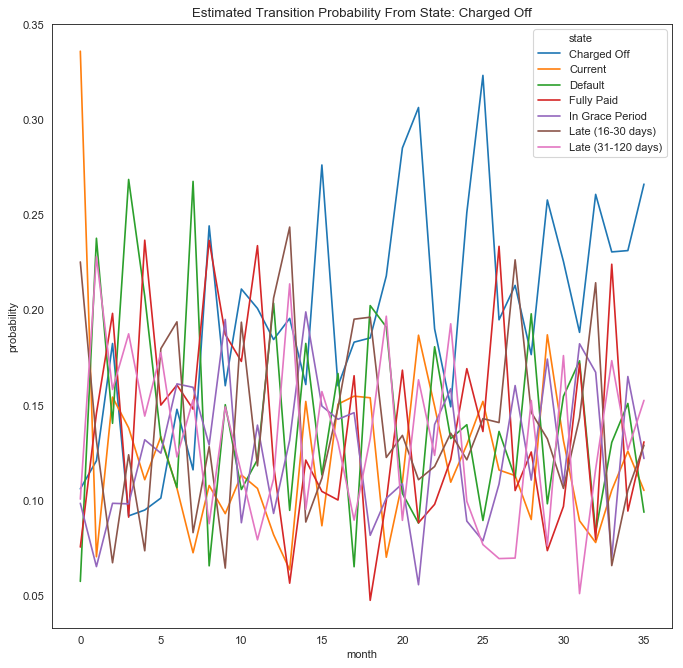

In [13]:
plot_probs_from_state_j(inferred_matrices, 'Charged Off')

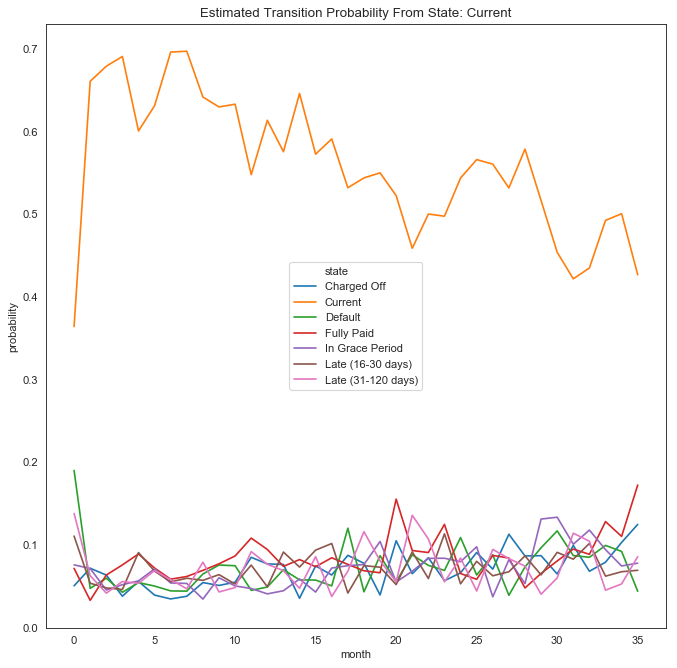

In [17]:
plot_probs_from_state_j(inferred_matrices, 'Current')

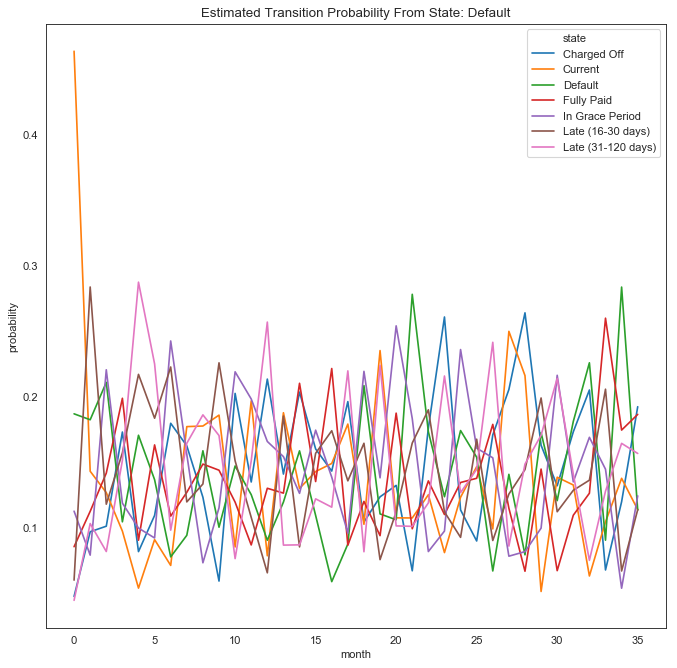

In [18]:
plot_probs_from_state_j(inferred_matrices, 'Default')

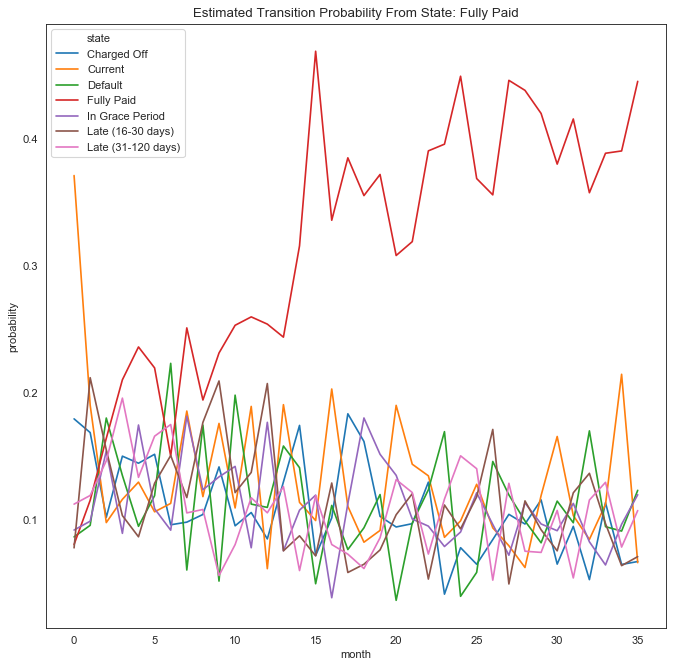

In [19]:
plot_probs_from_state_j(inferred_matrices, 'Fully Paid')

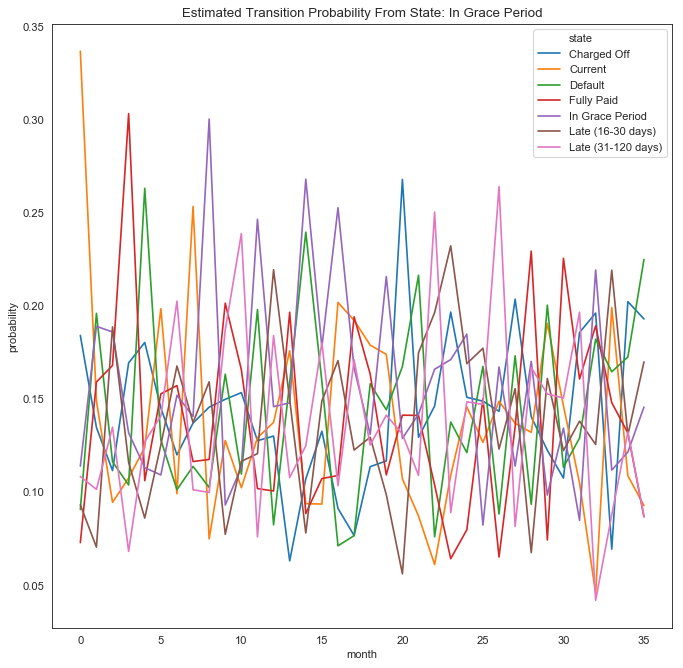

In [20]:
plot_probs_from_state_j(inferred_matrices, 'In Grace Period')

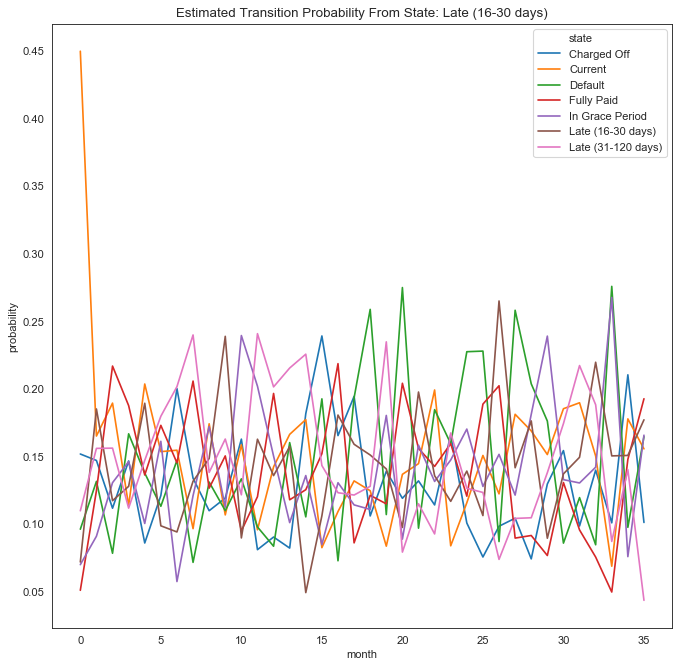

In [21]:
plot_probs_from_state_j(inferred_matrices, 'Late (16-30 days)')

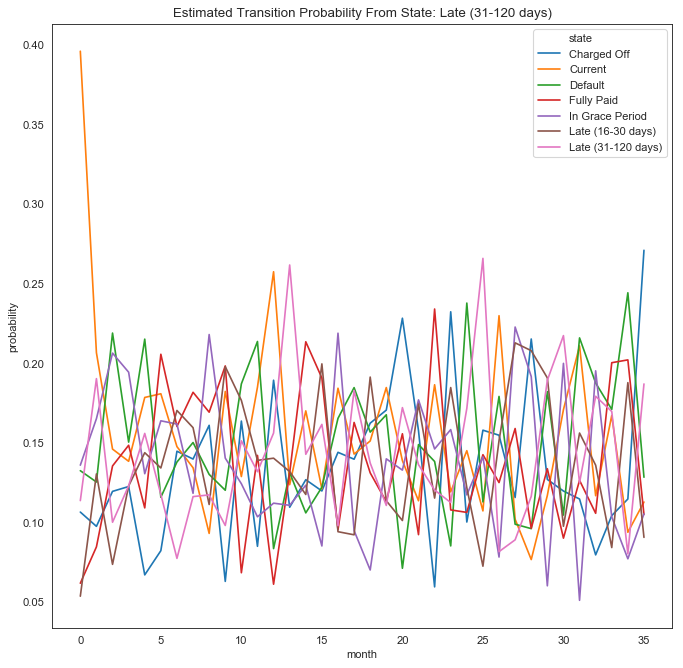

In [22]:
plot_probs_from_state_j(inferred_matrices, 'Late (31-120 days)')

## Experiment 5: Modeling counts of transitions, as a multinomial

### 5.1 Model

In [257]:
pi_list, counts = utils.models.build_multinomial(
    n_states, chain_len, total_counts_per_month=x_train.shape[0])

### 5.2 Inference (Batch)

For now we can just count states globally, but we should write another preprocessing function to count month per month instead (each month is a new drawing of the multinomial). This is mostly for test purposes.

**Pb** we need to add date information when loading the dataframe at the very first...

In [158]:
counts_per_month = utils.utils.get_counts_per_month(x_train, n_states)

Matrix of size (36, 7), total count of statuses per position in the MC.

In [258]:
reload(utils.inference)

<module 'utils.inference' from '/Users/jeromekafrouni/Documents/Cours/Columbia/Cours/Semestre 3/COMS 6998 Prob Programming/Project/lending-club-analysis/final-project/utils/inference.py'>

In [259]:
inferred_matrix, sess, qpi_list = utils.inference.infer_counts_multinomial(
    counts_per_month, pi_list, counts, x_train.shape[0], n_states, chain_len)

3000/3000 [100%] ██████████████████████████████ Elapsed: 27s | Loss: 11538680.000


In [261]:
round(inferred_matrix, 2)

,Charged Off,Current,Default,Fully Paid,In Grace Period,Late (16-30 days),Late (31-120 days)
0,0.05,0.67,0.05,0.06,0.05,0.05,0.05
1,0.05,0.68,0.05,0.05,0.05,0.05,0.05
2,0.06,0.65,0.06,0.06,0.06,0.06,0.06
3,0.06,0.66,0.05,0.06,0.06,0.06,0.06
4,0.05,0.69,0.05,0.07,0.05,0.05,0.05
5,0.05,0.67,0.05,0.07,0.05,0.05,0.05
6,0.06,0.63,0.06,0.09,0.05,0.05,0.06
7,0.05,0.65,0.05,0.09,0.05,0.05,0.05
8,0.05,0.62,0.05,0.12,0.05,0.06,0.05
9,0.05,0.65,0.05,0.12,0.05,0.05,0.05


### 5.3 Criticism

In [159]:
# TODO

## Experiment 6: Segmenting the loans / mixture model

Probably won't have much time to do something decent, maybe we can do the segmentation "by hand" though, i.e. not in edwards...

In [67]:
# TODO

## References

*Machine Learning: A Probabilistic Perspective*, by Kevin P. Murphy, MIT Press, 2012.

*The Dirichlet-Multinomial and Dirichlet-Categorical models for Bayesian inference*, by Stephen Tu, retrieved from https://people.eecs.berkeley.edu/~stephentu/writeups/dirichlet-conjugate-prior.pdf